In [ ]:
pip install -r requirements.txt

In [5]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from tqdm import tqdm
import cv2
import os
import sys
import imutils

### Image preprocessing ###

The original images contain black backgrounds of various sizes. Feeding these raw images into our model would result in lower accuracy because the model could pickup on background size as a feature for determining tumor type. To combat this, we can crop the images using the cv2 library. 

Below is an example of how we crop images from start to finish, as outlined in crop_image(img).

|Step 0 ) Original Image      |Step 1) Thresh Image                 |Step 2) Erode Image            | Step 3) Dilate Image         |Step 4) Crop Original Image |
|-----------------------------|-------------------------------------|-------------------------------|------------------------------|----------------------------|
| ![org](./utils/original.jpg)  |![thr](./utils/after_thresholding.jpg) |![ero](./utils/after_eroding.jpg)|![dil](./utils/after_dilate.jpg)|![cro](./utils/after_crop.jpg)|





In [6]:
def process_image(img,size):
    grayscale_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _,thresholded_image = cv2.threshold(grayscale_image, 10, 255, cv2.THRESH_BINARY)
    eroded_image = cv2.erode(thresholded_image, None, iterations=2)
    dilated_image = cv2.dilate(eroded_image, None, iterations=2)
    
    contours = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    points = max(contours, key=cv2.contourArea) # [[[x_val,y_valval]]]
    
    x_points = []
    y_points = []
    for point in points:
        x_points.append(point[0][0])
        y_points.append(point[0][1])

    left = min(x_points)
    right = max(x_points)
    top = min(y_points)
    bottom = max(y_points)

    cropped_image = img[top:bottom, left:right]
    resized_image = cv2.resize(cropped_image,(size,size))
    
    return resized_image

#### Running the code block below will call the crop_image(img) method on all images in the data folder.

Note: This only needs to be run once to generate all the processed data, duplicate runs will overwrite.

The processed images will be in a new folder named `processed_data`

In [7]:
training = sys.path[0]+"/data/Training"
testing = sys.path[0]+"/data/Testing"

IMAGE_SIZE = 256

for directory in os.listdir(training):
    if os.path.isfile(directory) or ".DS" in directory:
        continue
    new_folder = sys.path[0]+"/processed_data/Training/"+directory
    current_dir = training+"/"+directory
    
    if not(os.path.exists(new_folder)):
        os.makedirs(new_folder)
        
    for file in os.listdir(current_dir):
        if(file[0] =="."):
            continue
        image = cv2.imread(current_dir+"/"+file)
        processed_image = process_image(image,IMAGE_SIZE)
        cv2.imwrite(new_folder+'/'+file, processed_image)


for directory in os.listdir(testing):
    if os.path.isfile(directory) or ".DS" in directory:
        continue
    new_folder = sys.path[0]+"/processed_data/Testing/"+directory
    current_dir = testing+"/"+directory
    
    if not(os.path.exists(new_folder)):
        os.makedirs(new_folder)
        
    for file in os.listdir(current_dir):
        if(file[0] =="."):
            continue
        image = cv2.imread(current_dir+"/"+file)
        processed_image = process_image(image,IMAGE_SIZE)
        cv2.imwrite(new_folder+'/'+file, processed_image)

## Mapping the training data 

Our model is going to differentiate between 3  types of brain tumors: meningioma, pituitary, and glioma. Additionally, it is also possible for the patient to have no tumor at all.


The resulting output of our model will be a 4 dimensional vector v.

$$\begin{bmatrix} 1  \\ 0 \\ 0 \\ 0 \end{bmatrix}$$

The first value represents `notumor`, the second represents `glioma`, the third `meningioma` and the final value representing `pituitary`.

The cell below will prepare the training data and also add the corresponding labels for each image.

In [28]:
x_train=[]
y_train=[]
training=sys.path[0]+"/processed_data/Training"
classes = ["notumor", "glioma", "meningioma", "pituitary"]

for directory in os.listdir(training):
    if os.path.isfile(directory) or ".DS" in directory:
        continue
        
    current_dir = training+"/"+directory
    for file in os.listdir(current_dir):
        if(file[0] =="."):
            continue
        image = cv2.imread(current_dir+"/"+file)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        x_train.append(image)
        
        y_val = np.zeros(4,dtype=int)
        y_val[classes.index(directory)] = 1
        y_train.append(y_val)

x_train = np.array(x_train) / 255
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

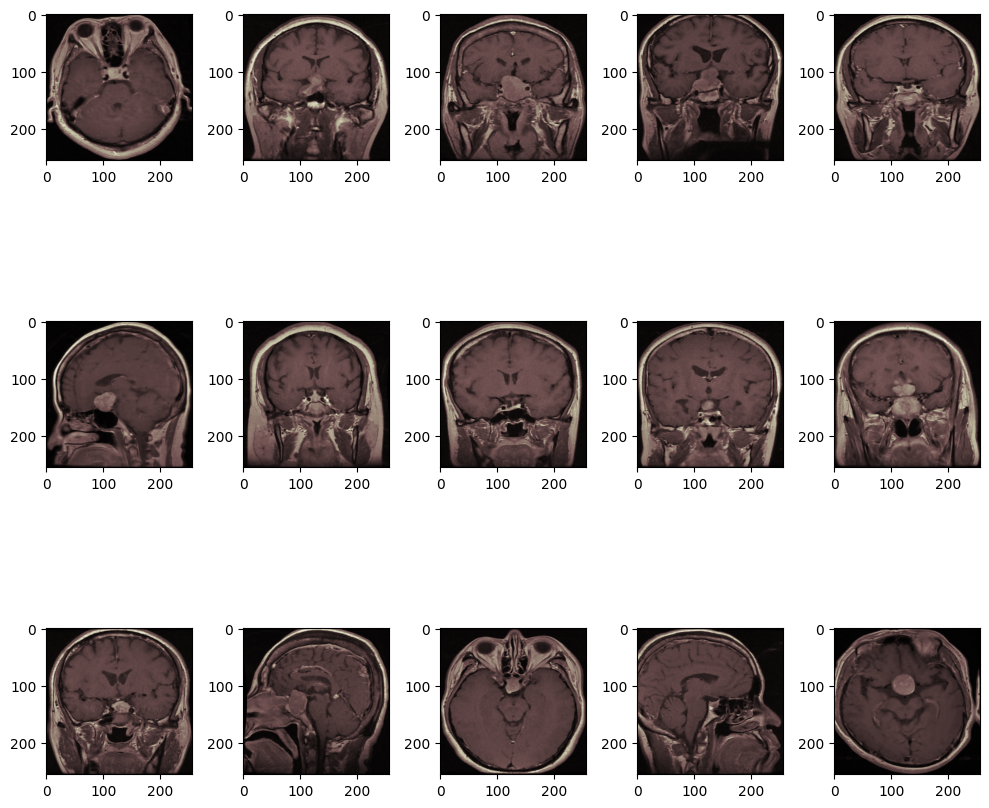

In [30]:
# for i in range(10):
#     # image = cv2.imread(x_train[i])

# print(y_train[1])
# print(x_train[1])
# image_size=256
# image = cv2.imread(training+"/glioma/Tr-gl_0010.jpg",0) # load images in gray.
# image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
# image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
# image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

### References 
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download

https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

https://docs.opencv.org/4.x/
                    
https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/